In [1]:
import sys
sys.path.append("/opt/SEP/lib/python3.8/")
sys.path.append("/home/users/arustam/fwix/operator/lib/python/")
sys.path.append("/home/users/arustam/fwix/propagator/lib/python/")
sys.path.append("/home/users/arustam/zfp/build/bin/")

In [2]:
%load_ext autoreload
%autoreload 2
import genericIO
import SepVector
import CudaOperator
import CudaWEM
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import zfpy

/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.8/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


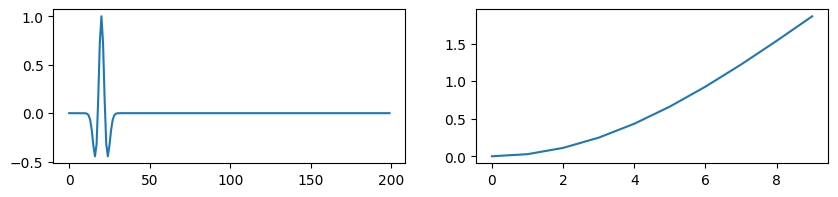

In [3]:
def ricker_wavelet(frequency, Nt, dt, t0=0):
    t = np.linspace(0, (Nt-1)*dt, Nt)
    t_shifted = t - t0
    ricker = (1 - 2 * (np.pi ** 2) * (frequency ** 2) * (t_shifted ** 2)) * np.exp(-(np.pi ** 2) * (frequency ** 2) * (t_shifted ** 2))
    return ricker

# Parameters
frequency = 10  # Ricker wavelet central frequency
Nt = 200    # Length of the wavelet in seconds
dt = 0.01      # Time sampling interval
t0 = 0.2

# Generate Ricker wavelet
wavelet = ricker_wavelet(frequency, Nt, dt, t0=t0)
W = np.fft.fft(wavelet)

dw = 1/((Nt-1)*dt) * 2*np.pi
nw = 10
f, a = plt.subplots(1,2, figsize=[10,2])
a[0].plot(wavelet, label='Ricker Wavelet')
a[1].plot(np.abs(W[:nw]), label="Spectrue")

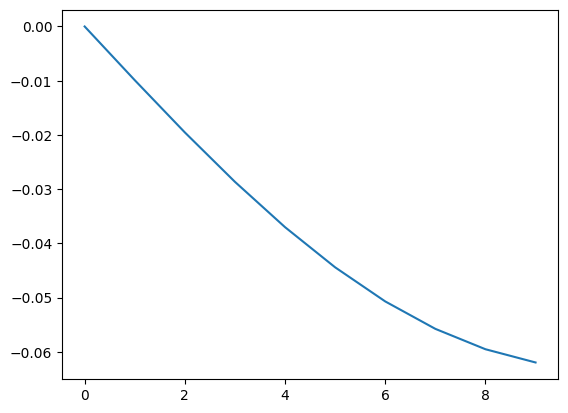

In [4]:
npml_t = 10 
amax = 1e-2

tpml = np.zeros(Nt)
tpml[:npml_t] = np.linspace(0, amax, npml_t)[::-1]
tpml[-npml_t:] = -tpml[:npml_t][::-1]

wpml = np.fft.fft(tpml)[:nw]

plt.plot(np.imag(wpml))

In [5]:
nx = 500
dx = 0.01
ny = 500
dy = 0.01
dw = 1.

ns = 1;
ds = 1

nz = 20;
dz = 0.01
nref = 11


total_wfld = SepVector.getSepVector(ns=[nx,ny,nw,ns,nz],ds=[dx,dy,dw,ds,dz],os=[0,0,1,0,0], storage='dataComplex')
wfld = SepVector.getSepVector(ns=[nx,ny,nw,ns],ds=[dx,dy,dw,ds],os=[0,0,1,0], storage='dataComplex')
slow = SepVector.getSepVector(ns=[nx,ny,nw,nz],ds=[dx,dy,dw,dz],os=[0,0,1,0], storage='dataComplex')

slow.set(1.)

slow[...,:,:nx//2] = 1.5
slow[...,:,nx//2:] = 2.
slow[...,:ny//2, :] = 2.5
slow[...,ny//2:, :] = 3

slow[...,:,:30].imag = -1e-2
slow[...,:,-30:].imag = -1e-2
slow[...,:30,:].imag = -1e-2
slow[...,-30:,:].imag = -1e-2

ntraces = ns
traces = SepVector.getSepVector(ns=[nw, ntraces],ds=[dw, 1],os=[1, 0], storage='dataComplex')

In [6]:
cx = np.random.uniform(0, (nx-1)*dx, ntraces)
cy = np.random.uniform(0, (ny-1)*dy, ntraces)
# cz = np.random.uniform(0, (nz-1)*dz, ntraces)
cz = [0]*ntraces
ids = np.random.randint(0, ns, ntraces)
ids = np.zeros(ntraces).astype(int)

In [7]:
injOp = CudaWEM.Injection(traces, total_wfld, cx, cy, cz, ids)

In [8]:
for i in range(ntraces):
    traces[i, :] = 1

In [9]:
injOp.forward(False, traces, total_wfld)

In [10]:
wfld[:] = total_wfld[0,...]

In [11]:
par = genericIO.pythonParams({"nref" : nref})

down = CudaWEM.Downward(wfld, wfld, slow, par)

In [12]:
%%time
down.forward(wfld)

CPU times: user 2.92 s, sys: 2.12 s, total: 5.05 s
Wall time: 5.18 s


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
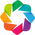

In [13]:
import holoviews as hv 
hv.extension('bokeh')
hv.output(widget_location='bottom')

In [14]:
snaps = {}
every = 1
pclip = .01

iw = 8
ishot = 0
amin = pclip * np.amin(wfld[:].real)
amax = pclip * np.amax(wfld[:].real)
# wfld_c = np.clip(wfld.real, amin, amax)

for i in range(0, ns, every):
    mat = wfld[i, iw,:,:].real
    snaps[i*dz] = hv.Image(mat, bounds=(0,-(ny-1)*dx,(nx-1)*dy,0)).opts(cmap='gray', clim=(amin, amax), aspect=nx/ny)

In [15]:
hmap = hv.HoloMap(snaps, kdims='Depth')
hmap

:HoloMap   [Depth]
   :Image   [x,y]   (z)

In [16]:
%%time
down.adjoint(wfld)

CPU times: user 3.02 s, sys: 1.99 s, total: 5.02 s
Wall time: 5.15 s


In [17]:
snaps = {}
every = 1
pclip = .01

iw = 8
ishot = 0
amin = pclip * np.amin(wfld[:].real)
amax = pclip * np.amax(wfld[:].real)
# wfld_c = np.clip(wfld.real, amin, amax)

for i in range(0, ns, every):
    mat = wfld[i, iw,:,:].real
    snaps[i*dz] = hv.Image(mat, bounds=(0,-(ny-1)*dx,(nx-1)*dy,0)).opts(cmap='gray', clim=(amin, amax), aspect=nx/ny)

In [18]:
hmap = hv.HoloMap(snaps, kdims='Depth')
hmap

:HoloMap   [Depth]
   :Image   [x,y]   (z)